# Swamp Angel observations of the surface radiative fluxes

### The analysis occurs below. The first several cells are just setting up the notebook

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Original Swamp Angel observations
dirDataRaw = dirPre + 'GroundObs/SenatorBeck/Raw'

## Load the Swamp Angel data

In [14]:
# Open netcdf
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SWA = SWA.loc[dict(time = slice(datetime(2003, 12, 1), datetime(2012, 8, 1)))]
# Resample to annual, monthly, and dialy to simplify later analysis
SWAmonth = SWA.resample(dim='time', how='mean', freq='m')
SWAday = SWA.resample(dim='time', how='mean', freq='d')

# Variance estimates
SWAmonth_std = SWAmonth.groupby('time.month').std(dim='time')

print(SWAmonth)
print(SWAday)

<xarray.Dataset>
Dimensions:    (time: 105)
Coordinates:
  * time       (time) datetime64[ns] 2003-12-31 2004-01-31 2004-02-29 ...
Data variables:
    WIND       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    SWup       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    SWdwn      (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    LWdwn      (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    snowDepth  (time) float64 0.8367 1.33 1.593 1.817 1.662 0.969 0.126 nan ...
    precip     (time) float64 2.034 1.132 2.566 1.052 2.425 0.2863 0.2833 ...
    RH         (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Tair       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    Tsrf       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    LWup       (time) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    groundTs   (time) float64 nan nan nan nan nan nan nan nan nan nan n

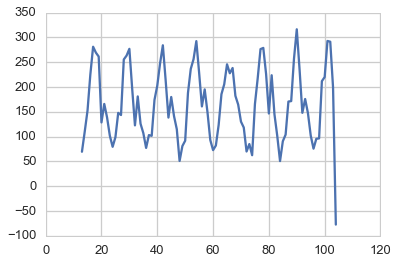

In [50]:
SWAmonth_var = (SWAmonth.groupby('time.month') - SWAmonth_std)
plt.plot(SWAmonth_var.SWdwn)

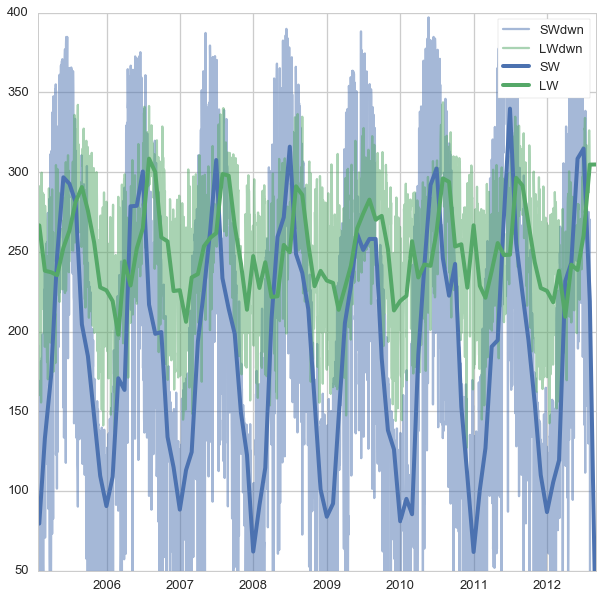

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
current_palette = sns.color_palette()

ax.plot(SWAday.time, SWAday.SWdwn, color=current_palette[0], alpha=0.5)
ax.plot(SWAday.time, SWAday.LWdwn, color=current_palette[1], alpha=0.5)
ax.plot(SWAmonth.time, SWAmonth.SWdwn, color=current_palette[0], label='SW', linewidth=4)
ax.plot(SWAmonth.time, SWAmonth.LWdwn, color=current_palette[1], label='LW', linewidth=4)

ax.set_ylim(50, 400)
ax.legend(frameon=True)

So here we have our first look at the radiative fluxes at Swamp Angel. Daily values are in the light background colors, the monthly averages are in the solid lines. 

Initial observations 

- The downwelling longwave, $Q_{li}$ exceeds the downwelling shortwave, $Q_{si}$ by a large margin for the winter
- During the summer the two reverse, but $Q_{si}$ > $Q_{li}$ by a small margin. This is easier to see in the monthly values.
- There is a gap in my data in the fall of 2012. I've dropped from August, 2012 and beyond in the cell where I load the data.

### Next, let's look at the annual average $Q_{li}$ and $Q_{si}$

I'm going to use the same colors for longwave and shortwave for the rest of the notebook.

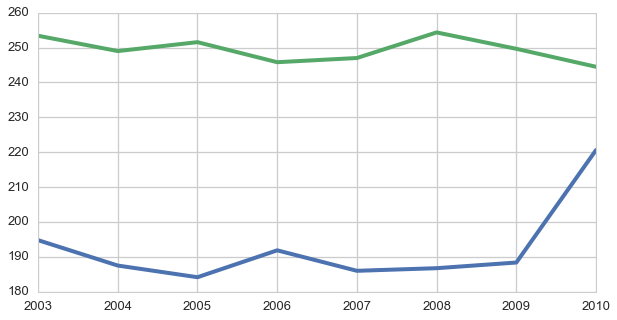

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
years = np.arange(2003, 2013).astype(int)

# Annual average shortwave
SWannual = SWA.SWdwn.groupby('time.year').mean(dim='time')
ax.plot(years, SWannual,
        color=current_palette[0], linewidth=4)

# Annual average longwave
LWannual = SWA.LWdwn.groupby('time.year').mean(dim='time')
ax.plot(years, SWA.LWdwn.groupby('time.year').mean(dim='time'),
        color=current_palette[1], linewidth=4)
_ = ax.set_xticklabels(years)

The annual average $Q_{li}$ is about 50 Wm-2 larger than $Q_{si}$. There is an indication of an anti-correlated behavior.

## Now the monthly composited irradiances

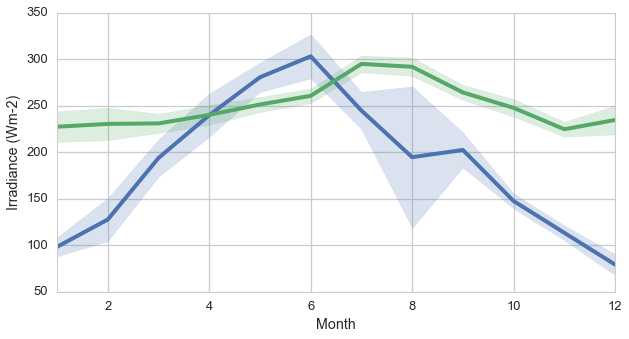

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

monthlyComposite = SWAmonth.groupby('time.month').mean(dim='time')
monthlyCompositeVar = SWAmonth.groupby('time.month').std(dim='time')
# Shortwave monthly composite mean with monthly composited variance

# Shortwave
ax.plot(monthlyComposite.month, monthlyComposite.SWdwn, color=current_palette[0], linewidth=4)
ax.fill_between(monthlyComposite.month,
                monthlyComposite.SWdwn - monthlyCompositeVar.SWdwn,
                monthlyComposite.SWdwn + monthlyCompositeVar.SWdwn,
                color=current_palette[0], alpha=0.2)
# Longwave
ax.plot(monthlyComposite.month, monthlyComposite.LWdwn, color=current_palette[1], linewidth=4)
ax.fill_between(monthlyComposite.month,
                monthlyComposite.LWdwn - monthlyCompositeVar.LWdwn,
                monthlyComposite.LWdwn + monthlyCompositeVar.LWdwn,
                color=current_palette[1], alpha=0.2)
# Format
ax.set_xlim(1, 12)
ax.set_ylabel('Irradiance (Wm-2)')
ax.set_xlabel('Month')

Here is where things get interesting. $Q_{si}$ is larger than $Q_{li}$ by a significant amount during the months of May and June. So McKenzie is right. The majority of the year $Q_{li}$ > $Q_{si}$, and often by a fairly large margin.


### Irradiance absorbed by the surface

Now comes the part that is less straightforward. How much energy is actually absorbed by the surface of the snow?

Energy abosrbed = (1 - spectral albedo) * Downwelling irradiance

For shortwave that's a rather straighforward calculation, we can just use the observed shortwave. Let's just keep in mind I've done nothing to correct the albedo for cloudiness or local slope.

For longwave, we need to estimate the emissivity. From the emissivity we can then arrive at the thermal albedo through:
albedo(longwave) ~ 1 - emissivity.

The emissivity of snow can vary between .99 and .9 depending on the surface type [Hori et al., 2006]. 0.9 is a lower bound that corresponds to sun glazed snow or icy surfaces. Typically, the emissivity of snow is above that value. So let's take a conservative view and assume that the spectrally-averaged longwave albedo is ~ 0.95. From that I will assume that the spectrally-averaged albedo of snow in the thermal wavelengths is 0.05.

The outgoing longwave irradiance should not be taken into account when considering the radiative energy absorbed by the snow. The outgoing longwave irradiance is energy emitted by the snow as a function of the snow's temperature. This is an entirely separate flux from the incoming longwave. Reflected shortwave and reflected longwave irradiances are energy never absorbed by the surface. Photons that are reflected are never seen by the snow from an energy perspective.

1. Hori, M. et al. In-situ measured spectral directional emissivity of snow and ice in the 8–14 μm atmospheric window. Remote Sens. Environ. 100, 486–502 (2006).

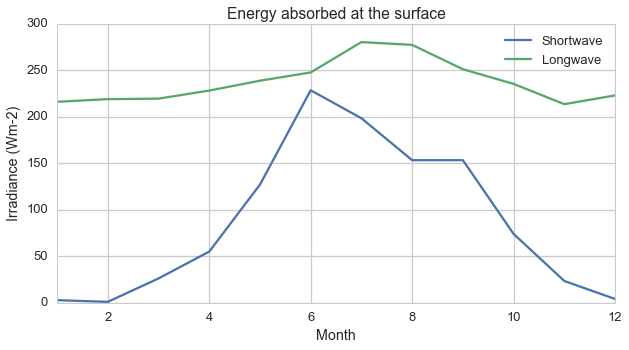

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(monthlyComposite.month,
        monthlyComposite.SWdwn - monthlyComposite.SWup,
        color=current_palette[0], label='Shortwave')
ax.plot(monthlyComposite.month,
        monthlyComposite.LWdwn - (0.05 * monthlyComposite.LWdwn),
        color=current_palette[1], label='Longwave')
ax.set_title('Energy absorbed at the surface')
ax.set_ylabel('Irradiance (Wm-2)')
ax.set_xlim(1, 12)
ax.set_xlabel('Month')
ax.legend()

I've run out of time this afternoon to update this figure to include the variance in the absorbed energy. But, once we consider the energy absorbed by the surface, the longwave irradiance emerges as the undisputed largest flux, rather than the largest flux for most conditions. Also keep in mind that the Senator Beck Basin is at a very high elevation with exceptionally low water vapor content. As we move down in elevation the relative role of the longwave irradiance increases due to the enhanced thermal emissivity and the enhanced solar absorption and scattering from water vapor and the overall depth of the air mass. 